Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Exploring baseline CONCEPT time step limiters for P3M

## Set up the environment and parameters

In [1]:
# pyright: reportWildcardImportFromLibrary=false
from wip3m import *

In [2]:
workdir = ROOT_PATH + "results/"
output_path = OUTPUT_PATH

# L = 8  # Box size in Mpc/h
# N = 8  # Density grid size
# Np = 8  # Number of dark matter particles per spatial dimension
# Npm = 16  # PM grid size
# n_Tiles = 2  # Make sure Npm/n_Tiles >= 6

# L = 16  # Box size in Mpc/h
# N = 16  # Density grid size
# Np = 16  # Number of dark matter particles per spatial dimension
# Npm = 32  # PM grid size
# n_Tiles = 4  # Make sure Npm/n_Tiles >= 6

# L = 32  # Box size in Mpc/h
# N = 32  # Density grid size
# Np = 32  # Number of dark matter particles per spatial dimension
# Npm = 256  # PM grid size
# n_Tiles = 32  # Make sure Npm/n_Tiles >= 6

# L = 64  # Box size in Mpc/h
# N = 64  # Density grid size
# Np = 64  # Number of dark matter particles per spatial dimension
# Npm = 128  # PM grid size
# n_Tiles = 16  # Make sure Npm/n_Tiles >= 6

# STANDARD PARAMETERS:
L = 32  # Box size in Mpc/h
N = 32  # Density grid size
Np = 32  # Number of dark matter particles per spatial dimension
Npm = 64  # PM grid size
n_Tiles = 8  # Make sure Npm/n_Tiles >= 6

go_beyond_Nyquist_ss = True  # for the summary statistics
    
force = force_hard = True
run_id = "notebook4"

TimeStepDistribution = 1 # 0: constant time step, 1: log
nsteps = 30

In [3]:
# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.field import read_field
from pysbmy.timestepping import StandardTimeStepping

from wip3m.tools import get_k_max, generate_sim_params, generate_white_noise_Field, run_simulation
from wip3m.params import params_CONCEPT_kmax_missing, cosmo_small_to_full_dict, z2a, BASELINE_SEEDPHASE
from wip3m.plot_utils import *  # type: ignore

In [4]:
corner = 0.0
RedshiftLPT = 199.0
# RedshiftLPT = 19.0
RedshiftFCs = 0.0
ai = z2a(RedshiftLPT)
af = z2a(RedshiftFCs)
k_max = get_k_max(L, N)  # k_max in h/Mpc
print(f"k_max = {k_max}")
# cosmo = params_planck_kmax_missing.copy()
cosmo = params_CONCEPT_kmax_missing.copy()
cosmo["k_max"] = k_max

wd = workdir + run_id + "/"
simdir = output_path + run_id + "/"
logdir = simdir + "logs/"
if force_hard:
    import shutil
    if Path(simdir).exists():
        shutil.rmtree(simdir)
    if Path(wd).exists():
        shutil.rmtree(wd)
Path(wd).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

input_white_noise_file = simdir + "input_white_noise.h5"
input_seed_phase_file = simdir + "seed"
ICs_path = simdir + "initial_density.h5"
simpath = simdir

# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

# Paths to the time step logs
OutputTimestepsLog = simdir + "timesteps_log.txt"

k_max = 5.442


### Generate the parameter files

In [5]:
common_params = {
    "Np": Np,
    "N": N,
    "L": L,
    "corner0": corner,
    "corner1": corner,
    "corner2": corner,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file
lpt_params["ICsMode"] = 1
lpt_params["InputWhiteNoise"] = input_white_noise_file

p3m_params = common_params.copy()
p3m_params["method"] = "p3m"
p3m_params["EvolutionMode"] = 4
p3m_params["TimeStepDistribution"] = TimeStepDistribution
p3m_params["ai"] = ai
p3m_params["af"] = af
p3m_params["RedshiftLPT"] = RedshiftLPT
p3m_params["RedshiftFCs"] = RedshiftFCs
p3m_params["Npm"] = Npm
p3m_params["nsteps"] = nsteps
p3m_params["n_Tiles"] = n_Tiles
p3m_params["RunForceDiagnostic"] = False
p3m_params["PrintOutputTimestepsLog"] = True
p3m_params["OutputTimestepsLog"] = OutputTimestepsLog

[09:25:47|INFO      ]|(wip3m.tools) Generating parameter file...
[09:25:47|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook4/example_lpt.sbmy'...
[09:25:47|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook4/example_lpt.sbmy' done.
[09:25:47|INFO      ]|(wip3m.tools) Parameter file written to /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook4/example_lpt.sbmy
[09:25:47|INFO      ]|(wip3m.tools) Time-stepping distribution file: /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook4/p3m_nsteps30_ts_p3m.h5
[09:25:47|STATUS    ]|Write timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/the

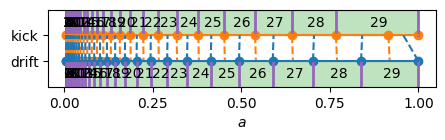

In [6]:
reset_plotting()  # Default style for Simbelmynë
generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)
file_ext = f"p3m_nsteps{p3m_params['nsteps']}"
generate_sim_params(p3m_params, ICs_path, wd, simdir, file_ext, force)
setup_plotting()  # Reset plotting style for this project

Load time stepping:

In [7]:
TS = StandardTimeStepping.read(wd + file_ext + "_ts_p3m.h5")
aKickBeg = TS.aKickBeg
aKickEnd = TS.aKickEnd
aDriftBeg = TS.aDriftBeg
aDriftEnd = TS.aDriftEnd
aiDrift = TS.aiDrift
afDrift = TS.afDrift

[09:25:47|STATUS    ]|Read timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook4/p3m_nsteps30_ts_p3m.h5'...
[09:25:47|STATUS    ]|Read timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook4/p3m_nsteps30_ts_p3m.h5' done.


### Generate the initial phase

In [8]:
generate_white_noise_Field(
    L=L,
    size=N,
    corner=corner,
    seedphase=BASELINE_SEEDPHASE,
    fname_whitenoise=input_white_noise_file,
    seedname_whitenoise=input_seed_phase_file,
    force_phase=force,
)

### Generating the input power spectrum

In [9]:
# If cosmo["WhichSpectrum"] == "class", then classy is required.
if not isfile(input_power_file) or force:
    Pk = PowerSpectrum(L, L, L, N, N, N, cosmo_small_to_full_dict(cosmo))
    Pk.write(input_power_file)

[09:25:47|STATUS    ]|Setting up Fourier grid...
[09:25:47|STATUS    ]|Setting up Fourier grid done.
[09:25:47|STATUS    ]|Computing normalization of the power spectrum...
[09:25:47|STATUS    ]|Computing normalization of the power spectrum done.
[09:25:47|STATUS    ]|Computing power spectrum...
[09:25:47|STATUS    ]|Computing power spectrum done.
[09:25:47|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook4/input_power.h5'...
[09:25:47|DIAGNOSTIC]==|L0=32, L1=32, L2=32
[09:25:47|DIAGNOSTIC]==|N0=32, N1=32, N2=32, N2_HC=17, N_HC=17408, NUM_MODES=464
[09:25:47|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook4/input_power.h5' done.


## Running the simulations

In [10]:
run_simulation("lpt", lpt_params, wd, logdir)

[09:25:47|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook4/example_lpt.sbmy /Users/hoellinger/WIP3M/notebook4/logs/lpt.txt
[09:25:47|INFO      ]|
[09:25:47|INFO      ]|            .-~~-.--.
[09:25:47|INFO      ]|           :         )
[09:25:47|INFO      ]|     .~ ~ -.\       /.- ~~ .
[09:25:47|INFO      ]|     >       `.   .'       <
[09:25:47|INFO      ]|    (         .- -.         )
[09:25:47|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[09:25:47|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[09:25:47|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[09:25:47|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[09:25:47|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________
[09:25:47|INFO      ]|       

In [11]:
run_simulation("p3m", p3m_params, wd, logdir)

[09:25:47|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook4/p3m_nsteps30_example_p3m.sbmy /Users/hoellinger/WIP3M/notebook4/logs/p3m_nsteps30p3m.txt
[09:25:47|INFO      ]|
[09:25:47|INFO      ]|            .-~~-.--.
[09:25:47|INFO      ]|           :         )
[09:25:47|INFO      ]|     .~ ~ -.\       /.- ~~ .
[09:25:47|INFO      ]|     >       `.   .'       <
[09:25:47|INFO      ]|    (         .- -.         )
[09:25:47|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[09:25:47|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[09:25:47|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[09:25:47|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[09:25:47|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________
[09:

[09:25:50|INFO      ]|(wip3m.plot_utils) Plotting timestep limiters from /Users/hoellinger/WIP3M/notebook4/timesteps_log.txt...
[09:25:51|INFO      ]==|(wip3m.plot_utils) Figure saved to: /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook4/time_step_diagnostics.pdf
[09:25:51|INFO      ]|(wip3m.plot_utils) Plotting timestep limiters from /Users/hoellinger/WIP3M/notebook4/timesteps_log.txt done.


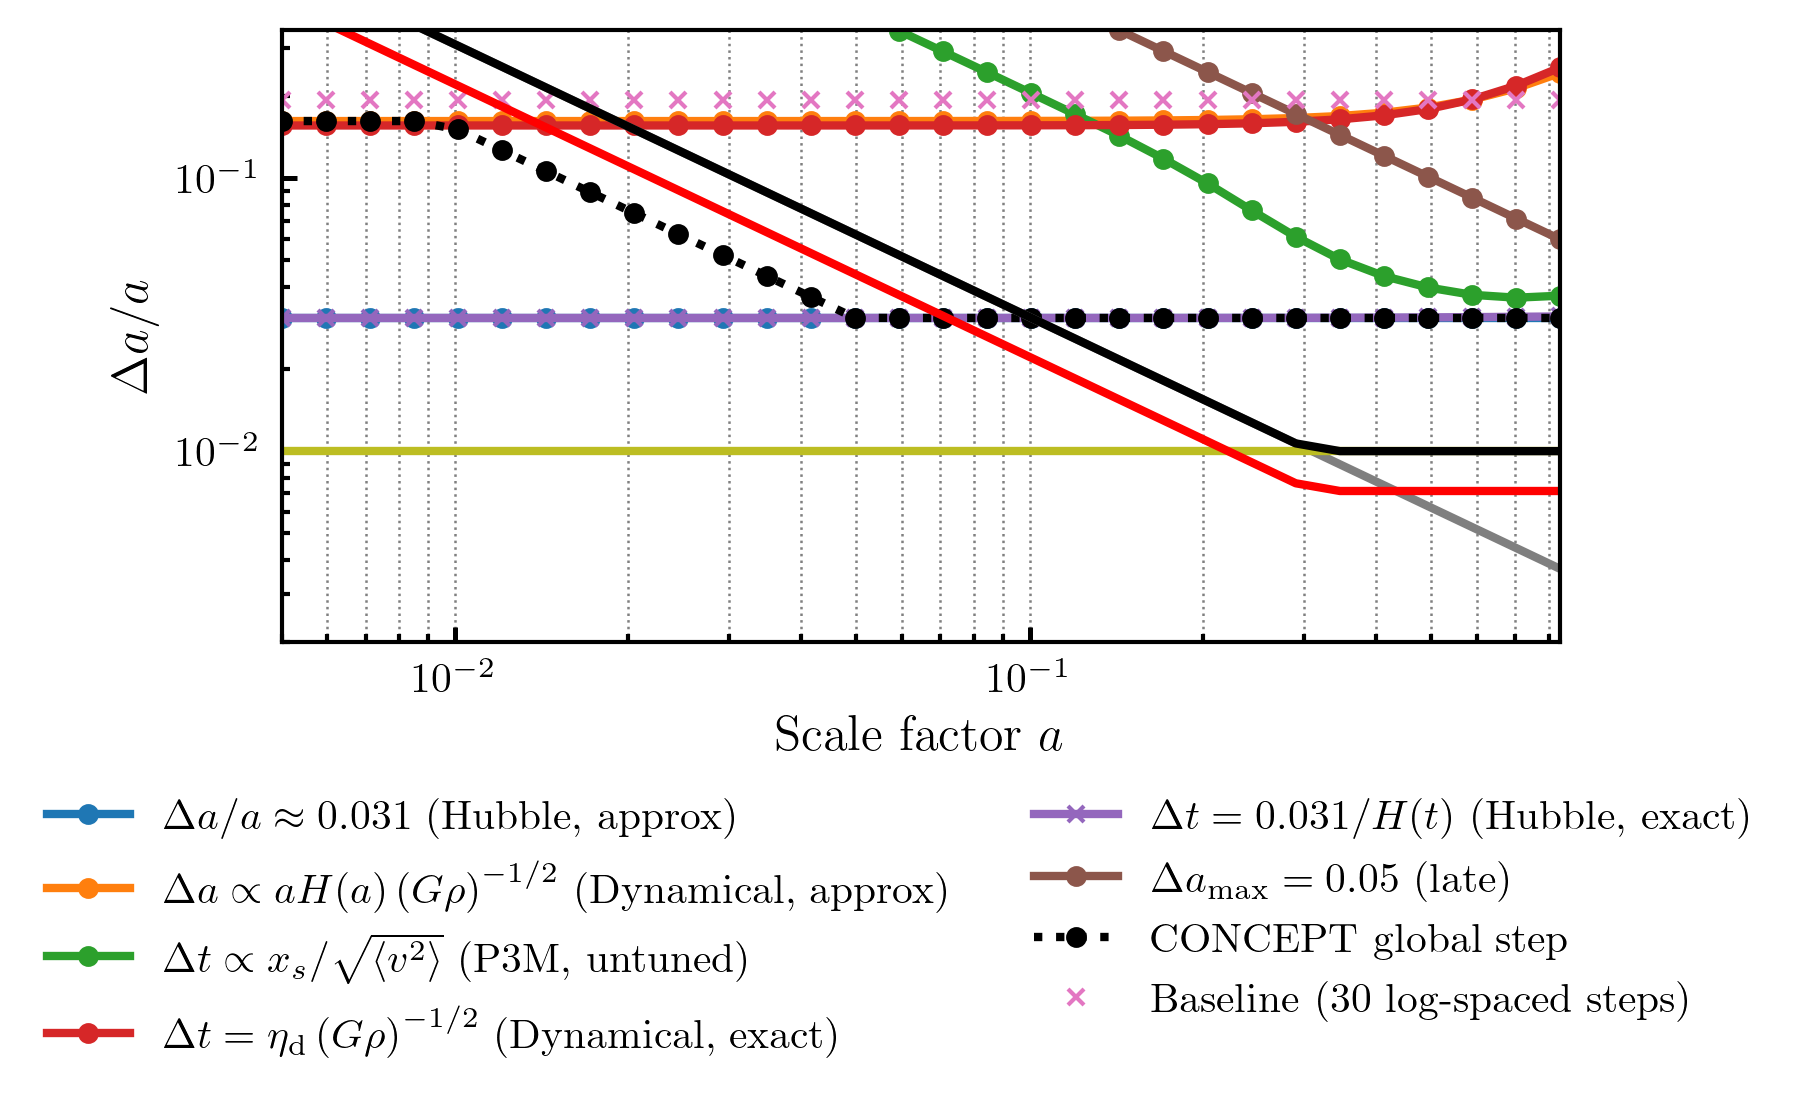

In [12]:
plot_timestepping_diagnostics(
    log_path=OutputTimestepsLog,
    aiDrift=aiDrift,
    TimeStepDistribution=TimeStepDistribution,
    nsteps=nsteps,
    save_path=wd+"time_step_diagnostics.pdf",
    show=False,
)
a = aiDrift
plt.loglog(a, 0.1 * 0.031 * np.ones_like(a) / a)
plt.loglog(a, 1e-2 * np.ones_like(a))
fac_p3m_concept = 0.14
lambda_p3m = lambda x, eta: eta * np.maximum(0.1 * 0.031 / x, 0.01)/fac_p3m_concept
approx_P3Mlim = lambda_p3m(a, fac_p3m_concept)
plt.loglog(a, approx_P3Mlim, color="black")
approx_P3Mlim_eta01 = lambda_p3m(a, 0.1)
plt.loglog(a, approx_P3Mlim_eta01, color="red")
plt.show()